# Overview of datasets
FROM https://github.com/theislab/perturbation-metrics/tree/main

In [2]:
import sys
sys.path.append("..")
from rosenbaum import *
import numpy as np
import scanpy as sc
import pandas as pd
from anndata import read_h5ad
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sc.set_figure_params(dpi=100, frameon=False, facecolor=None)

found cupy installation, will try use the GPU to calculate the distance matrix.


In [3]:
def scanpy_setup(adata):
    if 'counts' in adata.layers:
        adata.X = adata.layers['counts'].copy()
    else:
        adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e6, exclude_highly_expressed=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.pca(adata, use_highly_variable=True)
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    return adata

In [4]:
sc.logging.print_header()

scanpy==1.10.3 anndata==0.10.8 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [5]:
from itertools import cycle
import matplotlib.pyplot as plt

specific_colors = {
    'control': 'darkslateblue',
}
    
def plot(adata, groupby):
    adata.obs[groupby] = adata.obs[groupby].astype('category')
    sc.pl.umap(adata, size=10, color=[groupby], palette='viridis')
    
    # always assign the same color to control
    all_categories = adata.obs['perturbation'].cat.categories
    remaining_categories = set(all_categories) - set(specific_colors.keys())
    color_cycle = cycle(plt.cm.tab20.colors)
    color_map = {**specific_colors}
    for category in remaining_categories:
        color_map[category] = next(color_cycle)

    print(len(adata.obs.perturbation.unique()))
    sc.pl.umap(adata, size=10, color='perturbation', groups=['control'], palette=color_map, na_in_legend=False, title='control', legend_loc='none')

## mcfarland

In [6]:
adata = read_h5ad("/data_nfs/datasets/scrnaseq_ji/mcfarland.hdf5")

In [7]:
adata = scanpy_setup(adata)

/data/bionets/je30bery/anaconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/data/bionets/je30bery/anaconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [8]:
adata

AnnData object with n_obs × n_vars = 2649 × 2000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 2649 × 2000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

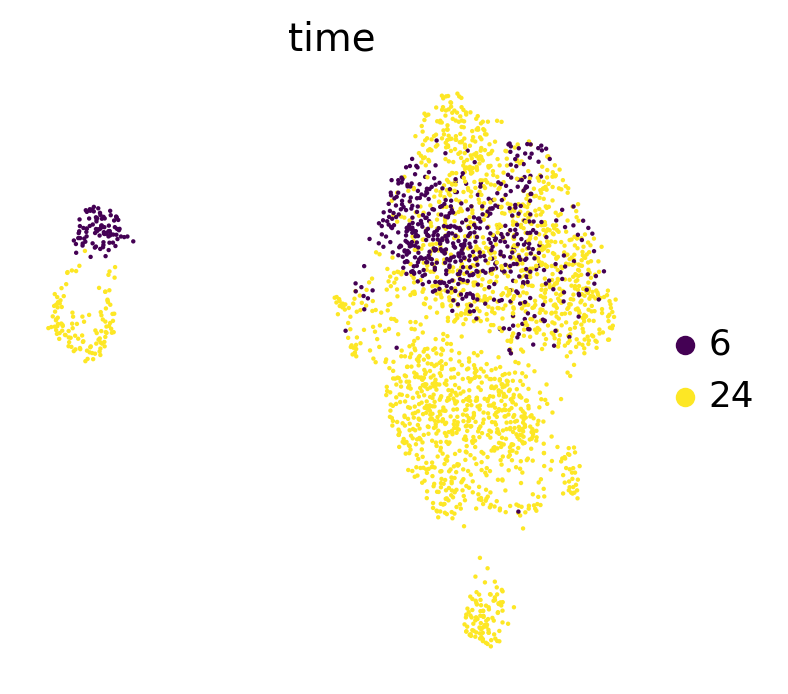

18


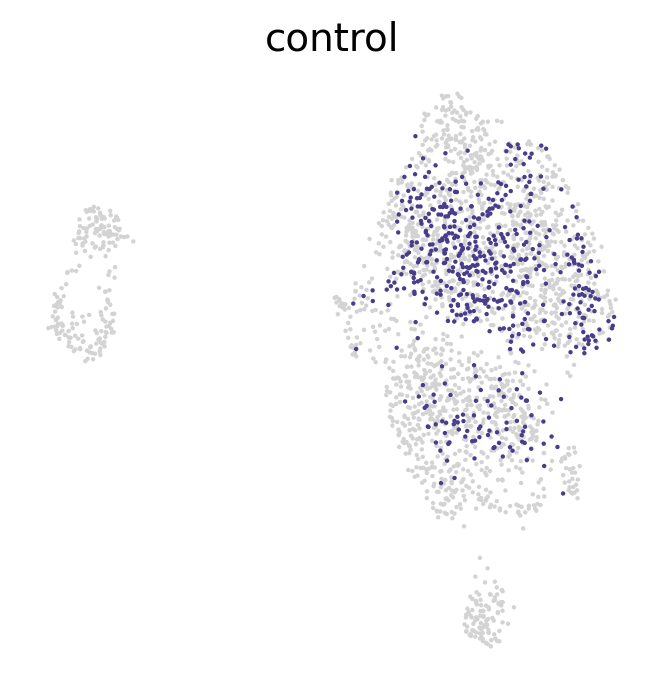

In [11]:
plot(adata, 'time')

In [12]:
adata.obs.time.value_counts()

time
24    1995
6      654
Name: count, dtype: int64

In [13]:
adata.obsp['connectivities']

<2649x2649 sparse matrix of type '<class 'numpy.float32'>'
	with 58268 stored elements in Compressed Sparse Row format>

In [ ]:
%%time

rosenbaum(adata, group_by="time", reference="control", test_group="6", rank=False, metric="sqeuclidean", k=15)

In [ ]:
adata.X